In [1]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import math
from tqdm import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
tf.config.run_functions_eagerly(True)


In [2]:
def generate_pink_noise(num_points):
    # Generate white noise
    white_noise = tf.random.normal([num_points])
    
    # Generate frequencies
    f = tf.range(1, num_points // 2 + 1, dtype=tf.float32)
    
    # Create 1/f spectrum
    spectrum = 1.0 / tf.sqrt(f)
    
    # Pad the spectrum for full FFT
    spectrum = tf.concat([tf.constant([1.0]), spectrum, tf.reverse(spectrum, [0])], 0)
    
    # Ensure spectrum has the same length as num_points
    if tf.shape(spectrum)[0] < num_points:
        spectrum = tf.pad(spectrum, [[0, num_points - tf.shape(spectrum)[0]]])
    else:
        spectrum = spectrum[:num_points]
    
    # Apply spectrum to white noise in frequency domain
    white_noise_fft = tf.signal.fft(tf.cast(white_noise, tf.complex64))
    pink_noise_fft = white_noise_fft * tf.cast(spectrum, tf.complex64)
    
    # Inverse FFT to get back to time domain
    pink_noise = tf.math.real(tf.signal.ifft(pink_noise_fft))
    
    # Normalize
    pink_noise = pink_noise / tf.math.reduce_std(pink_noise)
    
    return pink_noise
"""
# In your generate_sine_wave function:
def generate_sine_wave(params):
    frequency, amplitude, phase, Anoise, Fnoise = params
    x = tf.linspace(0.0, 2.0 * np.pi, num_points)
    wave = amplitude * tf.sin(frequency * x + phase)
    
    # Generate uniform noise
    uniform_noise = Anoise * tf.random.uniform(shape=(num_points,))
    
    # Generate pink noise
    pink_noise = generate_pink_noise(num_points) * Fnoise
    
    return wave + uniform_noise + pink_noise"""

'\n# In your generate_sine_wave function:\ndef generate_sine_wave(params):\n    frequency, amplitude, phase, Anoise, Fnoise = params\n    x = tf.linspace(0.0, 2.0 * np.pi, num_points)\n    wave = amplitude * tf.sin(frequency * x + phase)\n    \n    # Generate uniform noise\n    uniform_noise = Anoise * tf.random.uniform(shape=(num_points,))\n    \n    # Generate pink noise\n    pink_noise = generate_pink_noise(num_points) * Fnoise\n    \n    return wave + uniform_noise + pink_noise'

In [3]:
# Generate training data
"""
def generate_sine_wave_data(num_samples, num_points):
    x = np.linspace(0, 2 * np.pi, num_points)
    data = []
    for _ in range(num_samples):
        phase = np.random.uniform(0, 2 * np.pi)
        amplitude = np.random.uniform(0.5, 1.5)
        sine_wave = amplitude * np.sin(x + phase)
        data.append(sine_wave)
    return np.array(data)
"""
def training_sine_wave_with_noise(num_samples, num_points, frequency, Anoise, Fnoise):
    x = np.linspace(0, 2 * np.pi, num_points)
    data = []
    for _ in range(num_samples):
        phase = np.random.uniform(0, 2 * np.pi)
        amplitude = np.random.uniform(0.2, 0.5)
        sine_wave = amplitude * np.sin(frequency * x + phase)        
        # Generate noise and pink noise (1/f noise)
        noise_amplitude = Anoise
        noise = noise_amplitude * np.random.rand(num_points)
        noise_amplitude = Fnoise
        pink_noise = generate_pink_noise(num_points)
        pink_noise = tf.multiply(pink_noise, Fnoise)
        
        # Add pink noise to sine wave
        noisy_sine_wave = sine_wave + pink_noise+noise
        data.append(noisy_sine_wave)
    # Initialize MinMaxScaler
    scaler = MinMaxScaler()

    # Fit and transform the sine wave data
    data = scaler.fit_transform(data)
    
    return np.array(data)


2024-08-26 08:21:17.007634: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-08-26 08:21:17.007706: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-08-26 08:21:17.007718: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-08-26 08:21:17.007760: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-26 08:21:17.007790: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


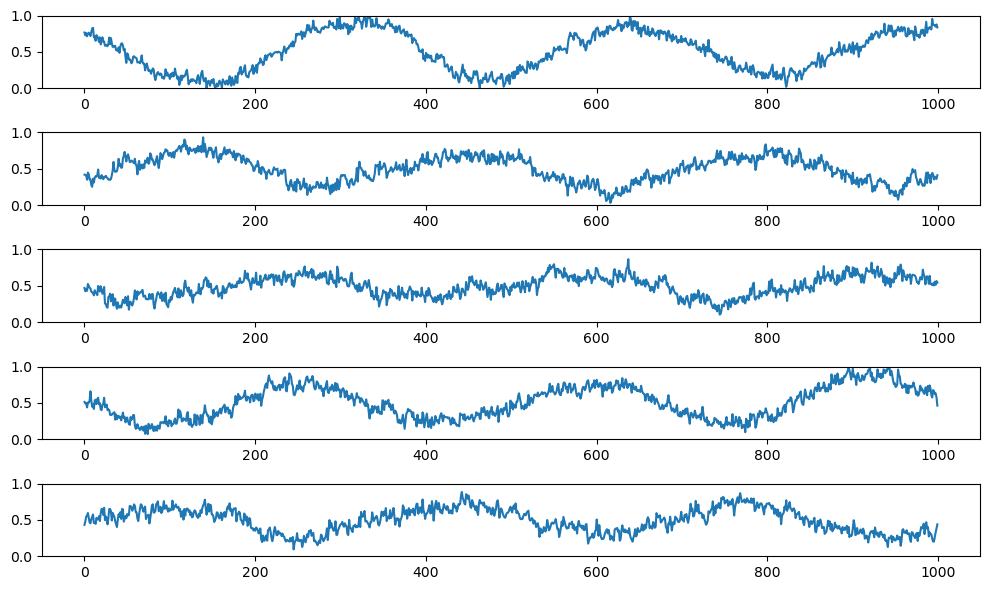

In [4]:
num_samples = 1000
num_points = 1000
tf.random.set_seed(123)
train_data = training_sine_wave_with_noise(num_samples, num_points, 3, .05, .1)


# Create a figure with two subplots (panels)
fig, axs = plt.subplots(5, 1, figsize=(10, 6))
for i in range(5):
    axs[i].plot(train_data[i] )
    axs[i].set_ylim([0,1])
plt.tight_layout()
plt.show()


In [13]:
# Define the generator model
"""def make_generator_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(100,)),
        #tf.keras.layers.Dense(128, activation='relu', input_shape=(100,)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(5)  # Output: [num_points, frequency, amplitude]
    ])
    return model """
def make_generator_model():
    noise_input = tf.keras.layers.Input(shape=(100,))
    x = tf.keras.layers.Dense(128, activation='relu')(noise_input)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    
    # Output layer without activation
    raw_output = tf.keras.layers.Dense(5)(x)
    
    # Apply appropriate activations/scaling to each output
    frequency = tf.keras.layers.Lambda(lambda x: tf.abs(x) + 0.1)(raw_output[:, 0:1])  # Positive, non-zero
    amplitude = tf.keras.layers.Lambda(lambda x: tf.abs(x))(raw_output[:, 1:2])  # Positive
    phase = tf.keras.layers.Lambda(lambda x: x * 2 * np.pi)(raw_output[:, 2:3])  # Any value, scaled to [0, 2π]
    Anoise = tf.keras.layers.Lambda(lambda x: tf.abs(x))(raw_output[:, 3:4])  # Positive
    Fnoise = tf.keras.layers.Lambda(lambda x: tf.abs(x))(raw_output[:, 4:5])  # Positive
    
    output = tf.keras.layers.Concatenate()([frequency, amplitude, phase, Anoise, Fnoise])
    
    return tf.keras.Model(inputs=noise_input, outputs=output)

def generate_sine_wave(params):
    frequency, amplitude, phase, Anoise, Fnoise = params
    
    x = tf.linspace(0.0, 2.0 * np.pi, num_points)
    wave = amplitude * tf.sin(frequency * x + phase)

    # Generate uniform noise
    uniform_noise = Anoise * tf.random.uniform(shape=(num_points,))

    # Generate pink noise (1/f noise)
    pink_noise = tf.random.normal(shape=(num_points,))
    pink_noise = generate_pink_noise(num_points)
    pink_noise = tf.multiply(pink_noise, Fnoise)
    pink_noise = tf.multiply(pink_noise, Fnoise)

    gwave = tf.add(wave, tf.add(uniform_noise, pink_noise))

    #Then to allow it to match training data have to minmax scale it too
    
    min_val = tf.reduce_min(gwave)
    max_val = tf.reduce_max(gwave)
    
    # Scale data to range [0, 1]
    return  (gwave - min_val) / (max_val - min_val)


# Define the discriminator model
"""
def make_discriminator_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(256, activation='relu', input_shape=(num_points,)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1)
    ])
    return model

def make_discriminator_model():
    model = tf.keras.Sequential([
        # Reshape input to add channel dimension
        tf.keras.layers.Reshape((num_points, 1), input_shape=(num_points,)),
        
        # 1D Convolutional layers
        tf.keras.layers.Conv1D(64, kernel_size=5, strides=2, padding='same', activation='leaky_relu'),
        tf.keras.layers.Conv1D(128, kernel_size=5, strides=2, padding='same', activation='leaky_relu'),
        tf.keras.layers.Conv1D(256, kernel_size=5, strides=2, padding='same', activation='leaky_relu'),
        
        # Global average pooling
        tf.keras.layers.GlobalAveragePooling1D(),
        
        # Dense layers
        tf.keras.layers.Dense(256, activation='leaky_relu'),
        tf.keras.layers.Dense(128, activation='leaky_relu'),
        
        # Output layer
        tf.keras.layers.Dense(1)
    ])
    return model
"""
def make_discriminator_model():
    inputs = tf.keras.Input(shape=(num_points,))
    
    # Reshape input to add channel dimension
    x = tf.keras.layers.Reshape((num_points, 1))(inputs)
    
    # 1D Convolutional layers
    x = tf.keras.layers.Conv1D(8, kernel_size=5, strides=2, padding='same', activation='leaky_relu')(x)
    x = tf.keras.layers.Conv1D(16, kernel_size=5, strides=2, padding='same', activation='leaky_relu')(x)
    x = tf.keras.layers.Conv1D(32, kernel_size=5, strides=2, padding='same', activation='leaky_relu')(x)
    x = tf.keras.layers.Dropout(0.3) (x)
    
    # Global average pooling
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    """
    # Dense layers
    x = tf.keras.layers.Dense(256, activation='leaky_relu')(x)
    x = tf.keras.layers.Dense(128, activation='leaky_relu')(x)"""
    
    # Output layer
    outputs = tf.keras.layers.Dense(1)(x)
    
    return tf.keras.Model(inputs=inputs, outputs=outputs)


# Loss functions and optimizers
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator = make_generator_model()
discriminator = make_discriminator_model()

generator_optimizer = tf.keras.optimizers.Adam(1e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)



In [14]:
# Training step
@tf.function
def train_step(real_data):
    #tf.print("Real data shape:", tf.shape(real_data))
    noise = tf.random.normal([batch_size, 100])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_params = generator(noise, training=True)
        #tf.print("Generated params shape:", tf.shape(generated_params))
        
        generated_data = tf.map_fn(generate_sine_wave, generated_params, fn_output_signature=tf.float32)
        
        real_output = discriminator(real_data, training=True)
        fake_output = discriminator(generated_data, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    return gen_loss, disc_loss

# Training loop
def train(dataset, epochs):
    steps_per_epoch = math.floor(num_samples / batch_size)
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        # Initialize loss accumulators for each epoch
        epoch_gen_loss = 0
        epoch_disc_loss = 0
        
        for step, batch in tqdm(enumerate(dataset), total=steps_per_epoch):
            if step >= steps_per_epoch:
                break  # Move to the next epoch          
            try:
                gen_loss, disc_loss = train_step(batch)
                epoch_gen_loss += gen_loss
                epoch_disc_loss += disc_loss
            except Exception as e:
                print(f"Error during training: {e}")
                break
        
        # Calculate average losses for the epoch
        avg_gen_loss = epoch_gen_loss / steps_per_epoch
        avg_disc_loss = epoch_disc_loss / steps_per_epoch

        clear_output(wait=True)
        print(f"Epoch {epoch + 1}/{epochs} - "
              f"Generator Loss: {avg_gen_loss:.4f}, "
              f"Discriminator Loss: {avg_disc_loss:.4f}")
        # Generate and plot sine waves
        egs=5
        
        # Generate and plot sine waves
        EgNoise = tf.random.normal([egs, 100])
        #print("EgNoise", EgNoise[0])
        generated_params = generator(EgNoise, training=False)
        print("params", generated_params[0])
        gen_waves=[]
        for i in range(egs):
            gen_waves.append( generate_sine_wave(generated_params[i]) )

        # Create a figure with two subplots (panels)
        fig, axs = plt.subplots(egs, 1, figsize=(10, 6))
        for i in range(egs):
            axs[i].plot(gen_waves[i] )
            #axs[i].set_ylim([0,1])
        plt.tight_layout()
        plt.show()
              
        if (epoch + 1) % 10 == 0:
            print(f"Completed {epoch + 1} epochs")
            plt.savefig(f"SineFigs/fig{epoch}.png")


In [15]:
batch_size = 10
train_dataset = tf.data.Dataset.from_tensor_slices(
    train_data).shuffle(num_samples).batch(batch_size, drop_remainder=True).repeat()

print("Dataset shape:", train_data.shape)
#print("Sample from dataset:", train_data[0])

Dataset shape: (1000, 1000)


In [16]:
epochs = 1000
train(train_dataset, epochs)

Epoch 1/1000


 24%|█████████████████████▎                                                                   | 24/100 [00:19<01:00,  1.26it/s]


KeyboardInterrupt: 

In [ ]:
egs=5

# Generate and plot sine waves
EgNoise = tf.random.normal([egs, 100])
generated_params = generator(EgNoise, training=False)

waves=[]
for i in range(egs):
    waves.append(train_data[i])

waves = np.concatenate(waves, axis=0)

gen_waves=[]
for i in range(egs):
    gen_waves.append( generate_sine_wave(generated_params[i]) )

gen_waves = np.concatenate(gen_waves, axis=0)

# Assuming you have 'waves' and 'gen_waves' arrays
# Modify the following line to match the actual length of your data

# Create a figure with two subplots (panels)
fig, axs = plt.subplots(2, 1, figsize=(10, 6))

# Plot the original sine waves in the first panel
axs[0].plot(waves, label='Original Sine Waves')
axs[0].set_title('Original Sine Waves')

# Plot the generated sine waves in the second panel
axs[1].plot(gen_waves, label='Generated Sine Waves', color='orange')
axs[1].set_title('Generated Sine Waves')

# Add labels, legends, and adjust layout
for ax in axs:
    ax.set_xlabel('Time')
    ax.set_ylabel('Amplitude')
    ax.legend()

plt.tight_layout()
plt.show()
